In [2]:
import pandas as pd
import datetime as dt
import swifter
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import copy
import pandas as pd
import swifter
import copy
import re

from pprint import pprint

# Functions

## HO Classify

In [3]:
def parse_mi_ho(f):

    df = pd.read_csv(f)
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=8)) 
    nr_pci = 'O'
    scells = []

    def NR_OTA(idx):

        if df["type_id"].iloc[idx] == "5G_NR_RRC_OTA_Packet": return True
        else: return False
    
    def LTE_SERV_INFO(idx):

        if df["type_id"].iloc[idx] == "LTE_RRC_Serv_Cell_Info": return True
        else: return False
    

    def find_1st_after(start_idx, target, look_after=1):
        for j in range(start_idx, len(df)):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t_ - t).total_seconds() > look_after:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before(start_idx, target, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before_with_special_value(start_idx, target, target_value, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] in [target_value] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_in_D_exact(targets):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.start).total_seconds(), target))

        if len(l) != 0:
            for x in l:
                if (x[0]== 0):
                    return x[1]
        
        return None
    
    def find_in_D_first_before(targets, look_before=1):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.end).total_seconds(), target, ho))

        if len(l) != 0:
            closest = min(filter(lambda x: x[0] > 0, l), key=lambda x: x[0])
            if 0 <= closest[0] < look_before:
                return closest[1], closest[2]
        
        return None, None

    HO = namedtuple('HO',['start', 'end', 'others', 'trans'], defaults=[None,None,'',''])
    
    D = {
        'Conn_Rel':[], 
        'Conn_Req':[], # Setup
        'LTE_HO': [], # LTE -> newLTE
        'MN_HO': [], # LTE + NR -> newLTE + NR
        'MN_HO_to_eNB': [], # LTE + NR -> newLTE
        'SN_setup': [], # LTE -> LTE + NR => NR setup
        'SN_Rel': [], # LTE + NR -> LTE
        'SN_HO': [], # LTE + NR -> LTE + newNR  
        'RLF_II': [],
        'RLF_III': [],
        'SCG_RLF': [],
        'Add_SCell': [],
        }
    
    for i in range(len(df)):

        # Pass NR RRC packet. In NSA mode, LTE RRC packet include NR packet message.
        if NR_OTA(i) or LTE_SERV_INFO(i):
            continue

        try: lte_pci, lte_earfcn
        except: 
            lte_pci = df["PCI"].iloc[i]
            lte_earfcn = int(df["Freq"].iloc[i])

        others = ''
        t = df["Timestamp"].iloc[i]

        if df["rrcConnectionRelease"].iloc[i] == 1:
            D['Conn_Rel'].append(HO(start=t))
            nr_pci = 'O'

        if df["rrcConnectionRequest"].iloc[i] == 1:
            
            # Define end of rrcConnectionRequest to be rrcConnectionReconfigurationComplete or securityModeComplete.
            a = find_1st_after(i, 'rrcConnectionReconfigurationComplete',look_after=2)[0]
            b = find_1st_after(i, 'securityModeComplete',look_after=2)[0]
        
            if a is None and b is None: end = None
            elif a is None and b is not None: end = b
            elif a is not None and b is None: end = a 
            else: end = a if a > b else b
            
            _, idx = find_1st_after(i, 'ueCapabilityInformation',look_after=1)
            if idx is not None:
                sup_band = df['bandEUTRA'].iloc[idx]
                others += f' supported band: {sup_band}.' 

            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            trans = f'({lte_pci}, {lte_earfcn}) -> ({serv_cell}, {serv_freq})'
            
            # Check if caused by RLF III.
            a, idx = find_1st_before(i, 'rrcConnectionReestablishmentReject', look_before=1)
            if a is not None:
                others += ' After RLF III.'

            D['Conn_Req'].append(HO(start=t,end=end,trans=trans, others=others))

            nr_pci = 'O'
            lte_pci = serv_cell
            lte_earfcn = serv_freq
            
        if df["lte-rrc.t304"].iloc[i] == 1:
            
            end, _ = find_1st_after(i, 'rrcConnectionReconfigurationComplete')
            serv_cell, target_cell = df["PCI"].iloc[i], int(df['lte_targetPhysCellId'].iloc[i])
            serv_freq, target_freq = int(df["Freq"].iloc[i]), int(df['dl-CarrierFreq'].iloc[i])

            lte_pci = target_cell
            lte_earfcn = target_freq

            if df["SCellToAddMod-r10"].iloc[i] == 1:
                n =len(str(df["SCellIndex-r10.1"].iloc[i]).split('@'))
                others += f' Set up {n} SCell.'
            else:
                scells = []
            
            if serv_freq != target_freq:
                a,b = find_1st_before(i, "rrcConnectionReestablishmentRequest", 1)
                others += " Inter frequency HO."
                if a is not None:
                    others += " Near after RLF."
                
            if df["nr-rrc.t304"].iloc[i] == 1 and df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 2)
                    
                    if a is not None:

                        ho_type, ho = find_in_D_first_before(['RLF_II', 'RLF_III'], 2)
                        others += f' Near after RLF of trans: {ho.trans}.'

                    else:
                        
                        ho_type, _ = find_in_D_first_before(['MN_HO_to_eNB', 'SN_Rel'], 2)
                        if ho_type is not None:
                            others += f' Near after {ho_type}.'

                    ori_serv = nr_pci
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) | {ori_serv} -> {nr_pci}'
                    D['SN_setup'].append(HO(start=t, end=end, others=others, trans=trans))

                else:
                    
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                    D['MN_HO'].append(HO(start=t, end=end, others=others, trans=trans))

            else:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, b = find_1st_before(i, "scgFailureInformationNR-r15")
                    if a is not None:
                        others += " Caused by scg-failure."
                    
                    orig_serv = nr_pci
                    nr_pci = 'O'
                    trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                    D['SN_Rel'].append(HO(start=t, end=end, others=others, trans=trans))
                    
                else:

                    a, _ = find_1st_before(i,"rrcConnectionSetup",3)
                    if a is not None:
                        others += ' Near After connection setup.'
                    if nr_pci == 'O':
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                        D['LTE_HO'].append(HO(start=t, end=end, others=others, trans=trans))
                    else:
                        orig_serv = nr_pci
                        nr_pci = 'O'
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {orig_serv} -> {nr_pci}'
                        D['MN_HO_to_eNB'].append(HO(start=t, end=end, others=others, trans=trans))


        if df["nr-rrc.t304"].iloc[i] == 1 and not df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
        
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            orig_serv = nr_pci
            nr_pci = int(df['nr_physCellId'].iloc[i])
            trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
            D['SN_HO'].append(HO(start=t,end=end,trans=trans))


        if df["rrcConnectionReestablishmentRequest"].iloc[i] == 1:

            end1, _ = find_1st_after(i, 'rrcConnectionReestablishmentComplete', look_after=1)
            b, _ = find_1st_after(i, 'rrcConnectionReestablishmentReject', look_after=1)
            end2, _ = find_1st_after(i, 'securityModeComplete',look_after=3)

            others += ' ' + df["reestablishmentCause"].iloc[i] + '.'
            scells = []

            c, _ = find_1st_before(i, 'scgFailureInformationNR-r15', 1)
            if c != None:
                others  += ' caused by scgfailure.'
                
            serv_cell, rlf_cell = df["PCI"].iloc[i], int(df['physCellId.3'].iloc[i])
            serv_freq = int(df['Freq'].iloc[i])
            
            # Type II & Type III
            if end1 is not None: 

                orig_serv = nr_pci
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                rlf_freq = int(df['Freq'].iloc[idx])
                trans = f'({rlf_cell}, {rlf_freq}) -> ({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_II'].append(HO(start=t,end=end1,others=others,trans=trans))

                lte_pci = serv_cell
                lte_earfcn = serv_freq

            elif b is not None and end2 is not None:
                
                orig_serv = nr_pci
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                rlf_freq = int(df['Freq'].iloc[idx])

                _, idx = find_1st_after(i, "rrcConnectionRequest", 2)
                recon_cell, recon_freq = df['PCI'].iloc[idx], int(float(df['Freq'].iloc[idx]))
                
                trans = f'({rlf_cell}, {rlf_freq}) -> ({recon_cell}, {recon_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_III'].append(HO(start=t,end=end2,others=others,trans=trans)) 

                # lte_pci, lte_earfcn will be updated in rrcConnectionRequest.     
                
            else:

                others+=' No end.'
                D['RLF_II'].append(HO(start=t,others=others))
                print('No end for RLF')

        if df["scgFailureInformationNR-r15"].iloc[i] == 1:

            others += ' ' + df["failureType-r15"].iloc[i] + '.'
            a, idx1 = find_1st_after(i, "rrcConnectionReestablishmentRequest", look_after=1)
            b, idx2 = find_1st_after(i, "lte-rrc.t304", look_after=10)

            if a is not None:

                end1, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentComplete', look_after=1)
                b, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentReject', look_after=1)
                end2 = find_1st_after(idx1, 'securityModeComplete',look_after=3)[0]

                others += ' Result in rrcReestablishment.'
                    
                # Type II & Type III Result
                if end1 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end1,others=others))
                elif b is not None and end2 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end2,others=others))
                else:
                    others += ' No end.'
                    D['SCG_RLF'].append(HO(start=t,others=others))
                    print('No end for scg failure result in rrcReestablishment.')

            elif b is not None:

                end, _ = find_1st_after(idx2, 'rrcConnectionReconfigurationComplete')
                serv_cell, target_cell = df["PCI"].iloc[idx2], df['lte_targetPhysCellId'].iloc[idx2]
                serv_freq, target_freq = int(df["Freq"].iloc[idx2]), df['dl-CarrierFreq'].iloc[idx2]
                # We do not change nr_pci here. Instead, we will change it at gNB_Rel event.
                trans = f'({serv_cell}, {serv_freq}) | {nr_pci} -> O'
                
                if serv_cell == target_cell and serv_freq == target_freq:
                    others += ' Result in gNB release.'
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))
                else:
                    others += ' Result in MN HO to eNB.'
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))                  

            else:

                print('No end for scg failure.')
                others += ' No end.'
                D['SCG_RLF'].append(HO(start=t,others=others))
        
        if df['SCellToAddMod-r10'].iloc[i] == 1 and df['physCellId-r10'].iloc[i] != 'nr or cqi report':

            others = ''
            pcis = str(df["physCellId-r10"].iloc[i]).split('@')
            freqs = str(df["dl-CarrierFreq-r10"].iloc[i]).split('@')
            orig_scells = scells
            scells = [(int(float(pci)), int(float(freq))) for pci, freq in zip(pcis, freqs)]

            others += f' Set up {len(scells)} SCell.'
            trans = f'{orig_scells} -> {scells}'

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
            
            a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 3)
            if a is not None:
                others += ' Near after RLF.'

            a = find_in_D_exact(['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel'])
            if a is not None:
                others += f' With {a}.'

            D['Add_SCell'].append(HO(start=t,end=end,others=others, trans=trans))
    
    return D


## Measurement Report

In [4]:
class REPORTCONFIG:
    def __init__(self, name, parameter):
        self.name = name.split(' ')[0]  
        self.parameters = self.parse_parameter(parameter)
    
    def parse_parameter(self, parameter):
        L = []
        start = False
        for i in range(len(parameter)):
            if parameter[i] == "'" and start == False:
                s = ''
                start = True
                continue
            
            if start:
                if parameter[i] == "'":
                    L.append(s)
                    start = False
                s += parameter[i]
        
        P = dict()
        filter = '+-0123456789[]()&'
        for i in range(0,len(L),2):
            x = ''
            for c in L[i+1]:
                if c in filter:
                    x += c
            try:
                P[L[i]] = int(x)
            except:
                P[L[i]] = x
        return P

    def __str__(self):
        return self.name

    def __repr__(self):
        return self.name

class MEASOBJ:

    def __init__(self, obj, freq):
        self.name = obj
        self.freq = freq

    def __str__(self):
        return f'({self.name}, {self.freq})'

    def __repr__(self):
        return f'({self.name}, {self.freq})'

def parse_measIdToAddMod(s):
    a = s.replace('(','')
    a = a.replace(')','')
    a = a.split('&')
    return (a[0], a[1], a[2])


In [5]:
def MeasureReport(file):

    mi_rrc_df = pd.read_csv(file)
    mi_rrc_df["Timestamp"] = mi_rrc_df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=8))
    unused = ['DL frequency','UL frequency', 'DL bandwidth', 'UL bandwidth', 'Cell Identity', 'TAC','Band ID', 'MCC', 'MNC']
    mi_rrc_df = mi_rrc_df.drop(columns=unused)
    mi_rrc_df = mi_rrc_df.dropna()    
    cols_to_covert = ['measObjectId', 'carrierFreq', 'carrierFreq-r15', 'lte-reportConfigId', 'lte-measIdToRemoveList', 'measId', 'ssbFrequency']
    mi_rrc_df[cols_to_covert] = mi_rrc_df[cols_to_covert].astype('str')

    measobj_dict, report_config_dict, measId_dict = {}, {}, {}
    nr_measobj_dict, nr_report_config_dict, nr_measId_dict = {}, {}, {}

    def reset():

        global measobj_dict, report_config_dict, measId_dict, nr_measobj_dict, nr_report_config_dict, nr_measId_dict  
        measobj_dict, report_config_dict, measId_dict = {}, {}, {}
        nr_measobj_dict, nr_report_config_dict, nr_measId_dict = {}, {}, {}

    MR = namedtuple('MR',['time', 'event', 'others'], defaults=[None,None,''])
    L = []

    RRC_connected = True
    Unknown = REPORTCONFIG('Unknown', {})

    for i in range(len(mi_rrc_df)):

        if mi_rrc_df['type_id'].iloc[i] == "5G_NR_RRC_OTA_Packet" or mi_rrc_df['type_id'].iloc[i] == "LTE_RRC_Serv_Cell_Info":
            continue

        time = mi_rrc_df['Timestamp'].iloc[i]
        others = ''
        
        # if mi_rrc_df["rrcConnectionRelease"].iloc[i] == 1:      
        #     reset()

        if mi_rrc_df["lte-measIdToRemoveList"].iloc[i] != '0':

            measIdToRemove_list = mi_rrc_df["lte-measIdToRemoveList"].iloc[i].split('@')
            if len(measIdToRemove_list) == 32:
                measId_dict = {}
            elif len(measId_dict) != 0:
                for a in range(len(measIdToRemove_list)):
                    try: measId_dict.pop(measIdToRemove_list[a])
                    except: pass

        if mi_rrc_df["lte-measurementReport"].iloc[i] == 1:
            
            others += 'E-UTRAN'
            id = str(int(float(mi_rrc_df['measId'].iloc[i])))

            try:
                x = measId_dict[id]
                event = report_config_dict[x[1]]
                mr = MR(time = time, event = event, others = others)
            except:
                mr = MR(time = time, event = copy.deepcopy(Unknown), others = others)

            L.append(mr)

        if mi_rrc_df["nr-measurementReport"].iloc[i] == 1:
            
            others += 'NR'
            id = str(int(float(mi_rrc_df['measId'].iloc[i])))

            try:
                x = nr_measId_dict[id]
                event = nr_report_config_dict[x[1]]
                mr = MR(time = time, event = event, others = others)
            except:
                mr = MR(time = time, event = copy.deepcopy(Unknown), others = others)
            
            L.append(mr)

        if mi_rrc_df["lte-MeasObjectToAddMod"].iloc[i] == 1:

            Id_list = mi_rrc_df["measObjectId"].iloc[i].split('@')
            measobj_list = mi_rrc_df["measObject"].iloc[i].split('@')
            carrierFreq_list = mi_rrc_df["carrierFreq"].iloc[i].split('@')
            carrierFreq_r15_list = mi_rrc_df["carrierFreq-r15"].iloc[i].split('@')
            
            for a in range(len(Id_list)):
                if measobj_list[a] == "measObjectEUTRA (0)":
                    measobj_dict[Id_list[a]] = MEASOBJ(measobj_list[a], carrierFreq_list[0])
                    carrierFreq_list.pop(0)
                elif measobj_list[a] == "measObjectNR-r15 (5)":
                    measobj_dict[Id_list[a]] = MEASOBJ(measobj_list[a], carrierFreq_r15_list[0])
                    carrierFreq_r15_list.pop(0)
    

        if mi_rrc_df["nr-MeasObjectToAddMod"].iloc[i] == 1:

            Id_list = mi_rrc_df["measObjectId"].iloc[i].split('@')
            measobj_list = mi_rrc_df["measObject"].iloc[i].split('@')
            ssbFrequency_list = mi_rrc_df["ssbFrequency"].iloc[i].split('@')

            for a in range(len(Id_list)):
                if measobj_list[a] == "measObjectNR (0)":
                    nr_measobj_dict[Id_list[a]] = MEASOBJ(measobj_list[a], ssbFrequency_list[0])
                    ssbFrequency_list.pop(0)     

            
        if mi_rrc_df["lte-ReportConfigToAddMod"].iloc[i] == 1:

            reportConfigId_list = mi_rrc_df["lte-reportConfigId"].iloc[i].split('@')
            eventId_list = mi_rrc_df["lte-eventId"].iloc[i].split('@')
            parameter_list = mi_rrc_df["lte-parameter"].iloc[i].split('@')
            for a in range(len(reportConfigId_list)):
                report_config_dict[reportConfigId_list[a]] = REPORTCONFIG(eventId_list[a], parameter_list[a])


        if mi_rrc_df["nr-ReportConfigToAddMod"].iloc[i] == 1: #############

            reportConfigId_list = mi_rrc_df["nr-reportConfigId"].iloc[i].split('@')
            eventId_list = mi_rrc_df["nr-eventId"].iloc[i].split('@')
            parameter_list = mi_rrc_df["nr-parameter"].iloc[i].split('@')
            for a in range(len(reportConfigId_list)):
                nr_report_config_dict[reportConfigId_list[a]] = REPORTCONFIG(eventId_list[a], parameter_list[a])

        if mi_rrc_df["lte-MeasIdToAddMod"].iloc[i] != '0':

            MeasIdToAdd_list = mi_rrc_df["lte-MeasIdToAddMod"].iloc[i].split('@')
            for a in range(len(MeasIdToAdd_list)):
                x = parse_measIdToAddMod(MeasIdToAdd_list[a])
                measId_dict[x[0]] = (x[1],x[2])


        if mi_rrc_df["nr-MeasIdToAddMod"].iloc[i] != '0' and mi_rrc_df["nr-MeasIdToAddMod"].iloc[i] != 0:

            MeasIdToAdd_list = mi_rrc_df["nr-MeasIdToAddMod"].iloc[i].split('@')
            for a in range(len(MeasIdToAdd_list)):
                x = parse_measIdToAddMod(MeasIdToAdd_list[a])
                nr_measId_dict[x[0]] = (x[1],x[2])

    # Sort to Dict
    types = ['eventA1','eventA2','E-UTRAN-eventA3', 'eventA5', 'eventA6','NR-eventA3', 'eventB1-NR-r15','reportCGI', 'reportStrongestCells', 'others']
    D = {k: [] for k in types}

    for mr in L:

        if 'E-UTRAN' in mr.others and 'eventA1' in mr.event.name:
            D['eventA1'].append(mr)
        
        elif 'E-UTRAN' in mr.others and 'eventA2' in mr.event.name:
            D['eventA2'].append(mr)  
        
        elif 'E-UTRAN' in mr.others and 'eventA3' in mr.event.name:
            D['E-UTRAN-eventA3'].append(mr)
        
        elif 'E-UTRAN' in mr.others and 'eventA5' in mr.event.name:
            D['eventA5'].append(mr)

        elif 'E-UTRAN' in mr.others and 'eventA6' in mr.event.name:
            D['eventA6'].append(mr)  
        
        elif 'E-UTRAN' in mr.others and 'eventB1-NR-r15' in mr.event.name:
            D['eventB1-NR-r15'].append(mr)
        
        elif 'E-UTRAN' in mr.others and 'reportCGI' in mr.event.name:
            D['reportCGI'].append(mr)
        
        elif 'E-UTRAN' in mr.others and 'reportStrongestCells' in mr.event.name:
            D['reportStrongestCells'].append(mr)
        
        elif 'NR' in mr.others and 'eventA3' in mr.event.name:
            D['NR-eventA3'].append(mr)       
        
        else:
            D['others'].append(mr)

    return D

## Map MeasureReport with HO

In [6]:
def map_MR_HO(MRs, HOs):

    map_ho_types = ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel', 'SN_HO', ]
    map_mr_types = ['E-UTRAN-eventA3', 'eventA5', 'eventB1-NR-r15', 'NR-eventA3']

    D = {'LTE_HO': [], 'NR_HO': [], 'SN_setup': []}

    for lte_ho_type in ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB']:
        for ho in HOs[lte_ho_type]:
            for mr_type in ['E-UTRAN-eventA3', 'eventA5', 'others']:
                
                for mr in MRs[mr_type]:
                    # The current mapping way may map a HO with repeated measurement report.
                    dif = (ho.start - mr.time).total_seconds()
                    if 0 < dif < 0.5:
                        D['LTE_HO'].append((mr, ho, lte_ho_type))

    for nr_ho_type in ['SN_Rel', 'SN_HO']:
        for ho in HOs[nr_ho_type]:
            for mr in MRs['NR-eventA3']:

                dif = (ho.start - mr.time).total_seconds()
                if 0 < dif < 0.5:
                    D['NR_HO'].append((mr, ho, nr_ho_type))

    for ho in HOs['SN_setup']:
        for mr in MRs['eventB1-NR-r15']:

            dif = (ho.start - mr.time).total_seconds()
            if 0 < dif < 0.5:
                D['SN_setup'].append((mr, ho, 'SN_setup'))

    return D 
                

## UE State

In [ ]:
def UE_state(file):

    mi_rrc_df = pd.read_csv(file)
    mi_rrc_df["Timestamp"] = mi_rrc_df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=8))
    unused = ['DL frequency','UL frequency', 'DL bandwidth', 'UL bandwidth', 'Cell Identity', 'TAC','Band ID', 'MCC', 'MNC']
    mi_rrc_df = mi_rrc_df.drop(columns=unused)
    mi_rrc_df = mi_rrc_df.dropna()

## HO Trace

In [7]:
def print_trans(HOs, p=True, mappings=None):

    All_HOs = []
    selected = ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel', 'SN_HO', 
    'Conn_Req' ,'RLF_II', 'RLF_III', 'SCG_RLF']

    for type in selected:

        for ho in HOs[type]:

            if type in ['LTE_HO', 'MN_HO', 'MN_HO_to_eNB'] and mappings is not None:
            
                target = mappings['LTE_HO']
                for mapping in target:
                    map_ho = mapping[1]
                    if ho == map_ho:
                        mr = mapping[0]
                        break
                    
                dif = (ho.start - mr.time).total_seconds()
                if 0 < dif < 0.5: 
                    All_HOs.append([type, ho, mr])
                else:
                    All_HOs.append([type, ho])

            elif type in ['SN_Rel', 'SN_HO'] and mappings is not None:
            
                target = mappings['NR_HO']

                for mapping in target:
                    map_ho = mapping[1]
                    if ho == map_ho:
                        mr = mapping[0]
                        break   

                dif = (ho.start - mr.time).total_seconds()
                if 0 < dif < 0.5: 
                    All_HOs.append([type, ho, mr])
                else:
                    All_HOs.append([type, ho])

            elif type in ['SN_setup'] and mappings is not None:
            
                target = mappings['SN_setup']

                for mapping in target:
                    map_ho = mapping[1]
                    if ho == map_ho:
                        mr = mapping[0]
                        break

                dif = (ho.start - mr.time).total_seconds()
                if 0 < dif < 0.5: 
                    All_HOs.append([type, ho, mr])
                else:
                    All_HOs.append([type, ho])
                
            else:
                All_HOs.append([type, ho])

    All_HOs = sorted(All_HOs, key = lambda x: x[1].start)

    if p:
        for ho in All_HOs:
            if len(ho) == 3:
                print(f'{ho[1].start} | {ho[0]} | {ho[1].trans} | {ho[2].event}')
            elif len(ho) == 2:
                print(f'{ho[1].start} | {ho[0]} | {ho[1].trans}')

    return All_HOs

# Main

## Visualized

In [31]:
file = '/home/wmnlab/D/database/2023-08-29/Modem_Control_Group/qc00/#01/data/diag_log_qc00_2023-08-29_15-25-58_rrc.csv'
HOs = parse_mi_ho(file)
MRs = MeasureReport(file)
mappings = map_MR_HO(MRs, HOs)
ordered_HOs1 = print_trans(HOs, mappings=mappings)

2023-08-29 15:26:20.875031 | SN_HO | (178, 3050) | O -> 394
2023-08-29 15:26:36.911781 | SN_HO | (178, 3050) | 394 -> 178 | eventA3
2023-08-29 15:26:41.544687 | SN_HO | (178, 3050) | 178 -> 122 | eventA3
2023-08-29 15:26:46.906709 | MN_HO_to_eNB | (178, 3050) -> (122, 3050) | 122 -> O | eventA3
2023-08-29 15:26:47.196932 | SN_setup | (122, 3050) | O -> 122 | eventB1-NR-r15
2023-08-29 15:26:49.345609 | MN_HO_to_eNB | (122, 3050) -> (130, 3050) | 122 -> O | eventA3
2023-08-29 15:26:49.594112 | SN_setup | (130, 3050) | O -> 503 | eventB1-NR-r15
2023-08-29 15:26:57.063000 | MN_HO | (130, 3050) -> (19, 3050) | 503 | eventA3
2023-08-29 15:26:59.815844 | MN_HO | (19, 3050) -> (130, 3050) | 503 | eventA3
2023-08-29 15:27:01.571734 | MN_HO | (130, 3050) -> (6, 3050) | 503 | eventA3
2023-08-29 15:27:02.587872 | SN_HO | (6, 3050) | 503 -> 511 | eventA3
2023-08-29 15:27:02.701269 | MN_HO | (6, 3050) -> (130, 3050) | 511 | eventA3
2023-08-29 15:27:06.463992 | MN_HO | (130, 3050) -> (11, 3050) | 511

In [32]:
file = '/home/wmnlab/D/database/2023-08-29/Modem_Control_Group/qc03/#01/data/diag_log_qc03_2023-08-29_15-25-58_rrc.csv'
HOs = parse_mi_ho(file)
MRs = MeasureReport(file)
mappings = map_MR_HO(MRs, HOs)
ordered_HOs2 = print_trans(HOs, mappings=mappings)

2023-08-29 15:26:10.248372 | MN_HO | (178, 3050) -> (386, 3050) | 503 | Unknown
2023-08-29 15:26:11.986599 | MN_HO | (386, 3050) -> (394, 3050) | 503 | eventA3
2023-08-29 15:26:18.532593 | MN_HO | (394, 3050) -> (178, 3050) | 503 | eventA3
2023-08-29 15:26:29.144356 | MN_HO | (178, 3050) -> (394, 3050) | 503 | eventA3
2023-08-29 15:26:31.426596 | MN_HO | (394, 3050) -> (178, 3050) | 503 | eventA3
2023-08-29 15:26:38.114403 | SN_HO | (178, 3050) | 503 -> 178 | eventA3
2023-08-29 15:26:39.884414 | SN_HO | (178, 3050) | 178 -> 122 | eventA3
2023-08-29 15:26:46.754293 | MN_HO_to_eNB | (178, 3050) -> (122, 3050) | 122 -> O | eventA3
2023-08-29 15:26:47.010753 | SN_setup | (122, 3050) | O -> 122 | eventB1-NR-r15
2023-08-29 15:26:48.780439 | SN_HO | (122, 3050) | 122 -> 503 | eventA3
2023-08-29 15:26:49.177544 | MN_HO | (122, 3050) -> (130, 3050) | 503 | eventA3
2023-08-29 15:27:01.058259 | MN_HO | (130, 3050) -> (6, 3050) | 503 | eventA3
2023-08-29 15:27:02.671485 | SN_HO | (6, 3050) | 503 -

In [11]:
# Useful Functions
def get_info(ordered_HOs, time_range):

    T, Type, Trans, Ev = [], [], [], []
    for element in ordered_HOs:
        NO_MR = False
        try:
            type, ho, mr = element[0], element[1], element[2]
        except:
            type, ho = element[0], element[1]
            NO_MR = True

        if ho.start < time_range[0]:
            continue
        elif time_range[1] < ho.start:
            break
        else: # in time range
            type = type.replace("_", " ")
            
            T.append(ho.start)
            Type.append(type)
            Trans.append(ho.trans)
            if NO_MR:
                Ev.append(mr.event)
            else:
                Ev.append(None)
    
    return T, Type, Trans, Ev

patterns = {
    'eNB HO': r'\((\d+), (\d+)\) -> \((\d+), (\d+)\)',
    'gNB HO': r'(\d+) -> (\d+)',
    'gNB setup': r'O -> (\d+)'
    }
def get_pci(string, type):
    pattern = patterns[type]
    match = re.match(pattern, string)

    if match:
        if type == 'eNB HO':
            return f'{match.group(1)}\u2192{match.group(3)}'
        elif type == 'gNB HO':
            return f'{match.group(1)}\u2192{match.group(2)}'
        elif type == 'gNB setup':
            return f'{match.group(1)}'
    return None

In [12]:
# Choose Style
# 'classic', 'ggplot', 'seaborn', 'Solarize_Light2', 'bmh', 'fivethirtyeight', 'dark_background', 'grayscale',  
plt.style.use('seaborn')

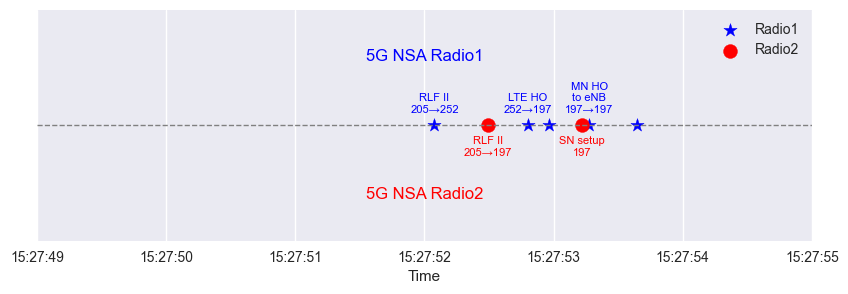

In [45]:
from matplotlib import dates
start_time = dt.datetime(2023, 8, 29, 15, 27, 49)
end_time = dt.datetime(2023, 8, 29, 15, 27, 55)
time_range = (start_time, end_time)

T1, Type1, Trans1, Ev1 = get_info(ordered_HOs1, time_range)
T2, Type2, Trans2, Ev2 = get_info(ordered_HOs2, time_range)

plt.figure(figsize=(10, 3)) 
plt.scatter(T1, [1] * len(T1), marker='*', color='b', label='A', s=100)
plt.scatter(T2, [1] * len(T2), marker='o', color='r', label='B', s=100)

plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)

for event, type, trans in zip(T1, Type1, Trans1):
    if type in ['LTE HO', 'MN HO', 'RLF II']:
        trans = trans.split(' | ')[0]
        text = type + '\n' + get_pci(trans, 'eNB HO')
    if type == 'MN HO to eNB':
        trans = trans.split(' | ')[0]
        text = 'MN HO\nto eNB'+ '\n' + get_pci(trans, 'eNB HO')
    elif type in ['SN HO']:
        trans = trans.split(' | ')[1]
        text = type + '\n' + get_pci(trans, 'gNB HO')
    elif type == 'SN setup':
        continue
        trans = trans.split(' | ')[1]
        text = type + '\n' + get_pci(trans, 'gNB setup')
    elif type == 'Conn Req':
        text = type + '\n' + get_pci(trans, 'eNB HO')
        
    plt.text(event, 1.005, text, ha='center', va='bottom', fontsize=8, color='b')

for event, type, trans in zip(T2, Type2, Trans2):
    if type in ['LTE HO', 'MN HO', 'RLF II']:
        trans = trans.split(' | ')[0]
        text = type + '\n' + get_pci(trans, 'eNB HO')
    if type == 'MN HO to eNB':
        trans = trans.split(' | ')[0]
        text = 'MN HO\nto eNB'+ '\n' + get_pci(trans, 'eNB HO')
    elif type in ['SN HO']:
        trans = trans.split(' | ')[1]
        text = type + '\n' + get_pci(trans, 'gNB HO')
    elif type == 'SN setup':
        trans = trans.split(' | ')[1]
        text = type + '\n' + get_pci(trans, 'gNB setup')
    elif type == 'Conn Req':
        text = type + '\n' + get_pci(trans, 'eNB HO')

    plt.text(event, 0.995, text, ha='center', va='top', fontsize=8, color='r')



# plt.title('Events of Radio1 & Radio2')
plt.xlabel('Time')
plt.yticks([])
plt.legend(['Radio1', 'Radio2'])
plt.xlim((start_time, end_time))

x_range = plt.xlim()
x_range = [dates.num2date(n).replace(tzinfo=None) for n in x_range]
y_range = plt.ylim()

plt.text((x_range[1] - x_range[0])*1/2+x_range[0], (y_range[1] - y_range[0])*4/5+y_range[0],  
        '5G NSA Radio1', ha='center', va='center', fontsize=12, color='b')
plt.text((x_range[1] - x_range[0])*1/2+x_range[0], (y_range[1] - y_range[0])*1/5+y_range[0], 
        '5G NSA Radio2', ha='center', va='center', fontsize=12, color='r')

plt.show()


In [19]:
Type2, Trans2

(['Conn Req', 'LTE HO', 'SN setup', 'SN HO', 'Conn Req', 'LTE HO', 'SN setup'],
 ['(378, 1750) -> (370, 3400)',
  '(370, 3400) -> (73, 3050) | O',
  '(73, 3050) | O -> 370',
  '(73, 3050) | 370 -> 73',
  '(73, 3050) -> (73, 1400)',
  '(73, 1400) -> (73, 1750) | O',
  '(73, 1750) | O -> 73'])

In [21]:
Type1, Trans1

(['MN HO to eNB',
  'LTE HO',
  'SN setup',
  'MN HO to eNB',
  'LTE HO',
  'SN setup',
  'MN HO to eNB',
  'LTE HO',
  'RLF II',
  'LTE HO',
  'LTE HO',
  'SN setup'],
 ['(370, 3650) -> (422, 3750) | 370 -> O',
  '(422, 3750) -> (370, 3650) | O',
  '(370, 3650) | O -> 362',
  '(370, 3650) -> (370, 3750) | 362 -> O',
  '(370, 3750) -> (370, 3650) | O',
  '(370, 3650) | O -> 370',
  '(370, 3650) -> (370, 3750) | 370 -> O',
  '(370, 3750) -> (362, 3650) | O',
  '(362, 3650) -> (49, 3650) | O -> O',
  '(49, 3650) -> (174, 3650) | O',
  '(174, 3650) -> (73, 3650) | O',
  '(73, 3650) | O -> 73'])